In [1]:
# In order to have a reference line, a base model will be trained with face cropped and aligned for bonafide vs printed vs screen classes (3 classes).
# - obj: train over FLICKR and eval with FLICKR

# take json files and gather data to training format -> bonafide vs imposter

In [2]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from imutils.paths import list_images
from sklearn.model_selection import train_test_split

from tensorflow.keras.metrics import FalsePositives, FalseNegatives, AUC

%load_ext autoreload
%autoreload 2

In [3]:
datapath = '../data/02_intermediate/flickr'
images_list = [*list_images(datapath)]
_classes = ('attack', 'bonafide')
_bf_index = _classes.index('bonafide')

In [4]:
epochs = 30
batch_size = 32
buffer_size = 8
_size = (224, 224)
bf, att = [], []

for imdir in images_list:
    if _classes[_bf_index] in imdir.split(os.sep): # if 'bonafide' in imdir
        bf.append(imdir)
    else:
        att.append(imdir)

In [5]:
len(bf), len(att)

(3000, 10975)

In [6]:
bf[0]

'../data/02_intermediate/flickr/bonafide/originales_ronda3y4/F12272.png'

In [7]:
def _parse_function(impath):
    # image reading
    image_string = tf.io.read_file(impath)
    image_decoded = tf.io.decode_png(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    image = tf.image.resize(image, _size)
    image = image / 255.
    
    # label setting
    _split = tf.strings.split(impath, sep=os.sep)
    _cls = _split[4]
    # 4th element is the class id
    if _cls == 'bonafide':
        lb = tf.cast([0, 1], tf.float32)
    else:
        lb = tf.cast([1, 0], tf.float32)
    
    return image, lb

# How to make dataset

In [10]:
# def train, test, val sets # done

In [11]:
bf_y = np.ones(len(bf))
att_y = np.zeros(len(att))

In [12]:
bf_y.shape, att_y.shape

((3000,), (10975,))

In [13]:
X = np.concatenate([bf, att])
y = np.concatenate([bf_y, att_y])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

# Train data

In [15]:
train_dataset = tf.cast(X_train, dtype=tf.string)
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.shuffle(buffer_size)
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.batch(batch_size)

# Val data

In [16]:
val_dataset = tf.cast(X_val, dtype=tf.string)
val_dataset = tf.data.Dataset.from_tensor_slices(val_dataset)
val_dataset = val_dataset.shuffle(buffer_size)
val_dataset = val_dataset.map(_parse_function)
val_dataset = val_dataset.cache()
val_dataset = val_dataset.batch(1)

# Test data

In [17]:
# test_dataset = tf.cast(X_test, dtype=tf.string)
# test_dataset = tf.data.Dataset.from_tensor_slices(test_dataset)
# test_dataset = val_dataset.shuffle(batch_size)
# test_dataset = val_dataset.map(_parse_function)
# test_dataset = val_dataset.cache()
# test_dataset = val_dataset.batch(1)

  0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]

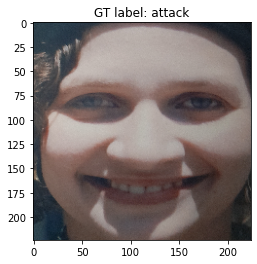

 10%|█████████████████▌                                                                                                                                                             | 1/10 [00:01<00:10,  1.20s/it]

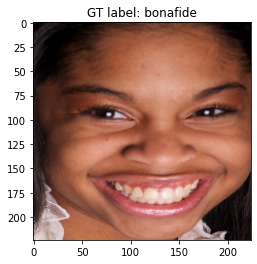

 20%|███████████████████████████████████                                                                                                                                            | 2/10 [00:02<00:09,  1.22s/it]

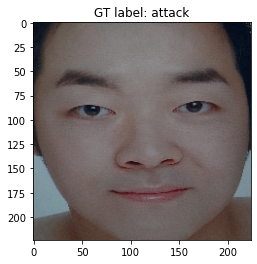

 30%|████████████████████████████████████████████████████▌                                                                                                                          | 3/10 [00:03<00:09,  1.35s/it]

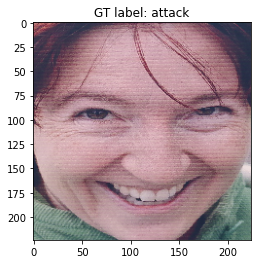

 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 4/10 [00:04<00:07,  1.18s/it]

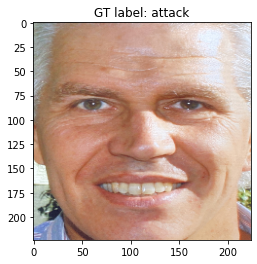

 50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:06<00:06,  1.24s/it]

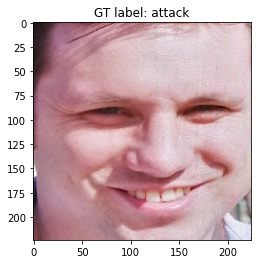

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 6/10 [00:07<00:05,  1.32s/it]

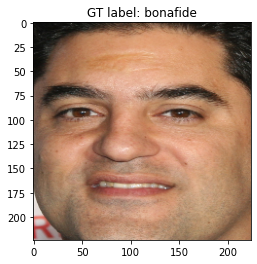

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 7/10 [00:08<00:03,  1.19s/it]

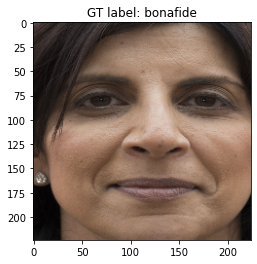

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 8/10 [00:09<00:02,  1.16s/it]

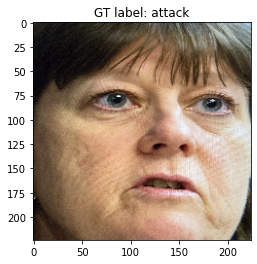

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 9/10 [00:10<00:01,  1.15s/it]

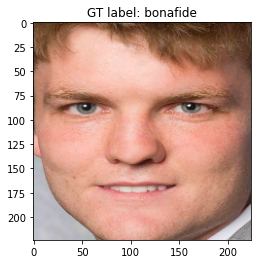

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


In [18]:
for bs in tqdm(val_dataset.take(5)):
    im, lb = bs
    
    _class_argmax = np.argmax(lb[0], axis=-1)
    plt.title(f'GT label: {_classes[_class_argmax]}')
    plt.imshow(im[0])
    plt.show()
    # break

In [19]:
# def model to be trained
# use aikit structure

In [20]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

In [21]:
input_shape = (*_size, 3) # 224x224x3

model = MobileNetV2(input_shape=input_shape, alpha=1.0, include_top=False, weights=None, pooling='max')

In [22]:
x = model.output
# Added by the 'pooling' argument
# x = GlobalAveragePooling2D()(x)
x = Dense(units=2, activation="softmax", use_bias=True, name="Logits")(x)

model = Model(inputs=model.input, outputs=x)

In [23]:
# model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [25]:
# compile model

learning_rate = 1e-4

loss = 'categorical_crossentropy'
# optimizer = Adam(learning_rate=learning_rate, amsgrad=True, decay=1e-6)
optimizer = SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True, decay=1e-6)

model.compile(
    optimizer=optimizer, 
    loss=loss, 
    metrics=['acc', FalsePositives(), FalseNegatives(), AUC(curve='PR')], 
)

In [26]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, use_multiprocessing=True, workers=8)

Epoch 1/30


2022-10-28 03:27:27.486233: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2022-10-28 03:27:27.934968: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-28 03:27:27.936012: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


263/263 [==============================] - 484s 2s/step - loss: 0.5935 - acc: 0.7497 - false_positives: 2099.0000 - false_negatives: 2099.0000 - auc: 0.7603 - val_loss: 0.6838 - val_acc: 0.7839 - val_false_positives: 604.0000 - val_false_negatives: 604.0000 - val_auc: 0.7462
Epoch 2/30
263/263 [==============================] - 43s 165ms/step - loss: 0.5583 - acc: 0.7587 - false_positives: 2023.0000 - false_negatives: 2023.0000 - auc: 0.7947 - val_loss: 0.6673 - val_acc: 0.7839 - val_false_positives: 604.0000 - val_false_negatives: 604.0000 - val_auc: 0.7462
Epoch 3/30
263/263 [==============================] - 43s 165ms/step - loss: 0.5524 - acc: 0.7665 - false_positives: 1958.0000 - false_negatives: 1958.0000 - auc: 0.7967 - val_loss: 0.6491 - val_acc: 0.7839 - val_false_positives: 604.0000 - val_false_negatives: 604.0000 - val_auc: 0.7462
Epoch 4/30
263/263 [==============================] - 44s 166ms/step - loss: 0.5174 - acc: 0.7705 - false_positives: 1924.0000 - false_negatives: 

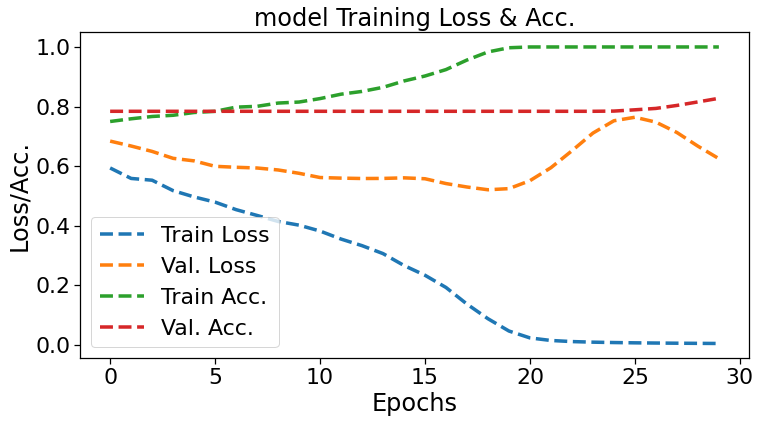

In [27]:
# define a plot function to plot history scores
def plot_history(history, title, save_path, figsize=(12, 6), font_scale=1, linewidth=3.5):
    with sns.plotting_context(
        "notebook", font_scale=2, rc={"lines.linewidth": linewidth}
    ):
        epochs = len(history.history["val_loss"])
        fig, ax = plt.subplots(figsize=figsize)
        ax.set_title(title)
        ax.set_ylabel("Loss/Acc.")
        ax.set_xlabel("Epochs")
        sns.lineplot(
            history.history["loss"], label="Train Loss", ax=ax, linestyle='--',
        )
        sns.lineplot(
            history.history["val_loss"], label="Val. Loss", ax=ax, linestyle='--',
        )
        sns.lineplot(
            history.history["acc"], label="Train Acc.", ax=ax, linestyle='--',
        )
        sns.lineplot(
            history.history["val_acc"], label="Val. Acc.", ax=ax, linestyle='--',
        )
        fig.savefig(save_path)


# call plot function
plot_history(history, "model Training Loss & Acc.", "train_plot.png")

In [28]:
# apply sklearn labelencoder

In [29]:
model.evaluate(val_dataset)

2795/2795 [==============================] - 11s 4ms/step - loss: 0.6249 - acc: 0.8275 - false_positives: 482.0000 - false_negatives: 482.0000 - auc: 0.9000


[0.624878466129303, 0.8275492191314697, 482.0, 482.0, 0.8999946117401123]